# Projet 5 - Segmentez des clients d'un site e-commerce

## Presentation du contexte et des objectifs

La [base de données](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce) à la source de ce projet provient de l'entreprise brésilienne Olist fondée en 2015. <br> Celle-ci propose une plateforme technologique facilitant la connexion entre les petits commerçants et les grands marketplaces en ligne (Mercado Livre, Americanas, Amazon…). Olist agit comme un agrégateur qui regroupe les catalogues de centaines de détaillants dans une vitrine unique, optimise les prix et gère la logistique et les paiements . <br>
La base de donnée fournie contient de nombreuses données anonymisées, à la fois sur les clients, les commandes, les produits et les vendeurs.

L'objectif de ce projet est double : <br>
- Segmenter les clients afin de mieux cibler les campagnes de communication
- Proposer un contrat de maintenance afin de savoir à quelle fréquence le modèle devra être réentrainé

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl

from datetime import datetime

from custom_library.outils import import_data

## Définir la requête SQL et importer les données

Je souhaite extraire la liste des clients (customer_id in customers), associés à la date de leur dernière commande (order_purchase_timestamp in orders), le nombre total de produits achetés (product_id in order_items), le nombre de commandes (order_id in orders), ainsi que la somme totale dépensée (payment_value in order_pymts). On ajoutera également le score moyen (review_score in order_reviews), le type de produit préféré (product_category_name_english in translation), et la région (customer_state in customers). Chaque ligne doit représenter un client. La méthode RFM est représentée par la date de la dernière commande (Récence), le nombre de commandes (Fréquence), et la somme totale dépensée (Montant).

Dans un souci de réutilisation, j'ai créé la méthode import_data dans le script outils.py permettant d'importer les données décrites ci-dessus sous forme de dataFrame à partir de la bdd.

In [2]:
date_fin = datetime.today().strftime('%Y-%m-%d')
data_all = import_data(date_fin)
print(data_all.shape)
print(data_all.dtypes)
data_all.head()

96096
(96096, 10)
[String, String, Int64, Int64, Float64, Float64, Float64, Float64, Float64, String]


customer_unique_id,customer_state,nb_commandes,nb_produits,prix_produit_total,prix_transport_total,depense_totale,recence,score_moyen,type_produit_prefere
str,str,i64,i64,f64,f64,f64,f64,f64,str
"""0000366f3b9a7992bf8c76cfdf3221…","""SP""",1,1,129.9,12.0,141.9,2609.544132,5.0,"""bed_bath_table"""
"""0000b849f77a49e4a4ce2b2a4ca5be…","""SP""",1,1,18.9,8.29,27.19,2612.533715,4.0,"""health_beauty"""
"""0000f46a3911fa3c08054444833370…","""SC""",1,1,69.0,17.22,86.22,3035.121493,3.0,"""stationery"""
"""0000f6ccb0745a6a4b88665a16c9f0…","""PA""",1,1,25.99,17.63,43.62,2819.146053,4.0,"""telephony"""
"""0004aac84e0df4da2b147fca70cf82…","""SP""",1,1,180.0,16.89,196.89,2786.176597,5.0,"""telephony"""


In [4]:
data_all.describe()

statistic,customer_unique_id,customer_state,nb_commandes,nb_produits,prix_produit_total,prix_transport_total,depense_totale,recence,score_moyen,type_produit_prefere
str,str,str,f64,f64,f64,f64,f64,f64,f64,str
"""count""","""96096""","""96096""",96096.0,95420.0,95420.0,95420.0,96095.0,96096.0,95380.0,"""94007"""
"""null_count""","""0""","""0""",0.0,676.0,676.0,676.0,1.0,0.0,716.0,"""2089"""
"""mean""",null,null,1.034809,1.18057,142.440198,23.599974,166.594226,2737.471995,4.084963,null
"""std""",null,null,0.214384,0.62145,217.656355,22.878663,231.428912,153.416318,1.341661,null
"""min""","""0000366f3b9a7992bf8c76cfdf3221…","""AC""",1.0,1.0,0.85,0.0,0.0,2449.270625,1.0,"""agro_industry_and_commerce"""
"""25%""",null,null,1.0,1.0,47.9,14.08,63.12,2613.156424,4.0,null
"""50%""",null,null,1.0,1.0,89.9,17.6,108.0,2718.184884,5.0,null
"""75%""",null,null,1.0,1.0,155.0,25.54,183.53,2846.621053,5.0,null
"""max""","""ffffd2657e2aad2907e67c3e9daecb…","""TO""",17.0,24.0,13440.0,1794.96,13664.08,3222.114363,5.0,"""watches_gifts"""


## Nettoyer les données

### On vérifie que chaque client est bien représenté une seule fois dans le dataset

In [5]:
len(data_all['customer_unique_id'].unique()) == len(data_all['customer_unique_id'])

True

### Vérifier que la dépense totale est bien la somme du prix des produits et du prix du transport

On calcule le pourcentage de clients qui ont une erreur de plus de 1% sur leur dépense totale :

In [16]:
condition_match = np.abs(
			data_all["depense_totale"]
			- (data_all["prix_produit_total"] + data_all["prix_transport_total"])
		)> 0.01 * data_all["depense_totale"]

percent = np.round(
		condition_match.sum()/ len(data_all) * 100,
    2)

print(f"{percent}% des clients ont une erreur sur leur dépense totale qui est considérée trop importante (>1%)")

0.35% des clients ont une erreur sur leur dépense totale qui est considérée trop importante (>1%)


Comme la part d'erreur est faible, on se contente d'enlever du dataset les clients concernés : 

In [17]:
print(f"Avant filtrage il y avait {len(data_all)} clients")
data_filtered = data_all.loc[
    np.abs(
        data_all["depense_totale"]
        - (data_all["prix_produit_total"] + data_all["prix_transport_total"])
    )
    < (0.01 * data_all["depense_totale"]),
    :,
]
print(f"Après filtrage, il y a maintenant {len(data_filtered)} clients")

Avant filtrage il y avait 96096 clients


AttributeError: 'DataFrame' object has no attribute 'loc'

On a seulement besoin de la dépense totale, on peut enlever le prix des produits et du transport :

In [17]:
data_filtered = data_filtered.drop(
    ["prix_transport_total", "prix_produit_total"], axis=1
)

## Observer les données

In [18]:
numerics = ["int16", "int32", "int64", "float16", "float32", "float64"]
numeric_df = data_filtered.select_dtypes(include=numerics) #extract numeric columns

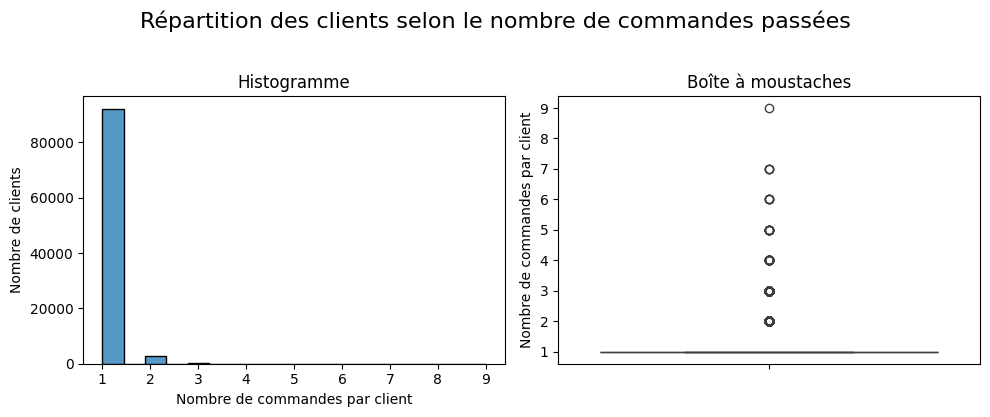

In [19]:
var = numeric_df["nb_commandes"]
var_str = "Nombre de commandes par client"

fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(10, 4))

sns.histplot(var, ax=axes[0])
axes[0].set_title("Histogramme")
axes[0].set_ylabel("Nombre de clients")
axes[0].set_xlabel(var_str)

sns.boxplot(var, ax=axes[1])
axes[1].set_title("Boîte à moustaches")
axes[1].set_ylabel(var_str)

fig.suptitle("Répartition des clients selon le nombre de commandes passées", fontsize=16, y=1.03)

plt.tight_layout()
plt.show()


La grande majorité des clients n'a fait qu'une seule commande. Séparons donc ces deux groupes de clients pour une observation plus détaillée

In [20]:
data_1_commande = numeric_df.loc[numeric_df['nb_commandes'] == 1]
data_plus_commandes = numeric_df.loc[numeric_df['nb_commandes'] > 1]

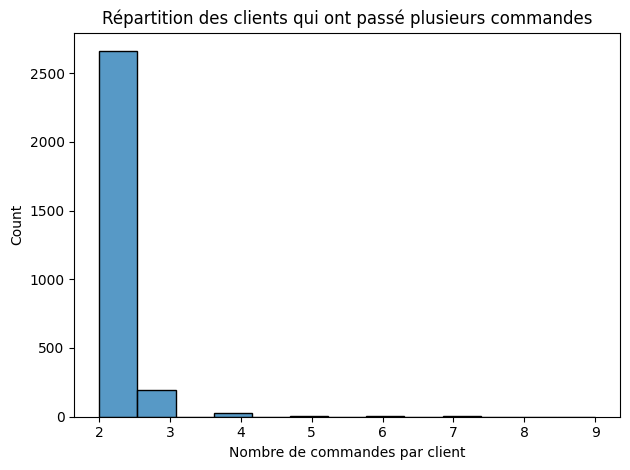

In [21]:
sns.histplot(data_plus_commandes['nb_commandes'])
plt.xlabel("Nombre de commandes par client")
plt.title("Répartition des clients qui ont passé plusieurs commandes")
plt.tight_layout()
plt.show()

Parmi la minorité de clients qui ont passé plusieurs commandes, la majorité a passé 2 commandes

In [22]:
print(f"Parmi les {len(numeric_df)} clients, {np.round(len(data_1_commande)/len(numeric_df)*100,2)} % ont passé une seule commande et parmi les {np.round(100-len(data_1_commande)/len(numeric_df)*100,2)} % restant, {np.round(len(data_plus_commandes.loc[data_plus_commandes['nb_commandes']==2])/len(data_plus_commandes)*100,2)} % ont passé 2 commandes")

Parmi les 95082 clients, 96.95 % ont passé une seule commande et parmi les 3.05 % restant, 91.85 % ont passé 2 commandes


Le dataset est donc très déséquilibré en terme de fréquence. Ceci rend difficile l'utilisation de la fréquence pour segmenter les clients et fragilise la méthode RFM.

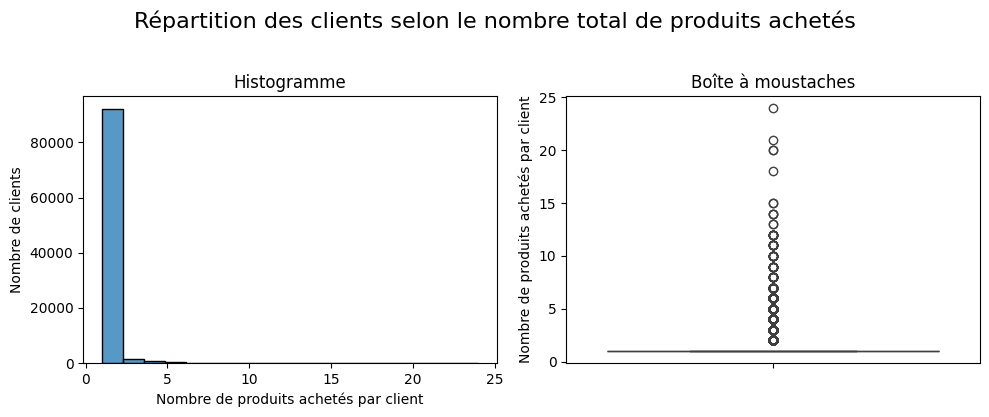

In [23]:
var = numeric_df["nb_produits"]
var_str = "Nombre de produits achetés par client"

fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(10, 4))

sns.histplot(var, ax=axes[0])
axes[0].set_title("Histogramme")
axes[0].set_ylabel("Nombre de clients")
axes[0].set_xlabel(var_str)

sns.boxplot(var, ax=axes[1])
axes[1].set_title("Boîte à moustaches")
axes[1].set_ylabel(var_str)

fig.suptitle("Répartition des clients selon le nombre total de produits achetés", fontsize=16, y=1.03)

plt.tight_layout()
plt.show()


De la même manière que pour le nombre de commande, qui est lié, on a un déséquilibre dans le nombre de produits achetés :

In [24]:
data_1_produit = numeric_df.loc[numeric_df['nb_produits'] == 1]
data_plus_produits = numeric_df.loc[numeric_df['nb_produits'] > 1]

In [25]:
print(f"Parmi les {len(numeric_df)} clients, {np.round(len(data_1_produit)/len(numeric_df)*100,2)} % ont acheté un seul produit.")

Parmi les 95082 clients, 87.57 % ont acheté un seul produit.


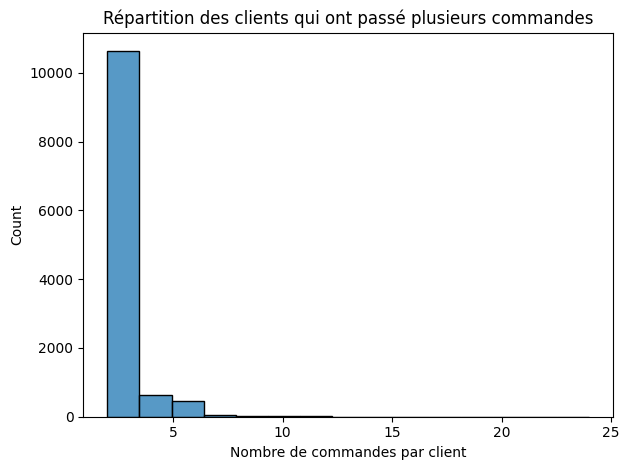

In [26]:
sns.histplot(data_plus_produits['nb_produits'])
plt.xlabel("Nombre de commandes par client")
plt.title("Répartition des clients qui ont passé plusieurs commandes")
plt.tight_layout()
plt.show()

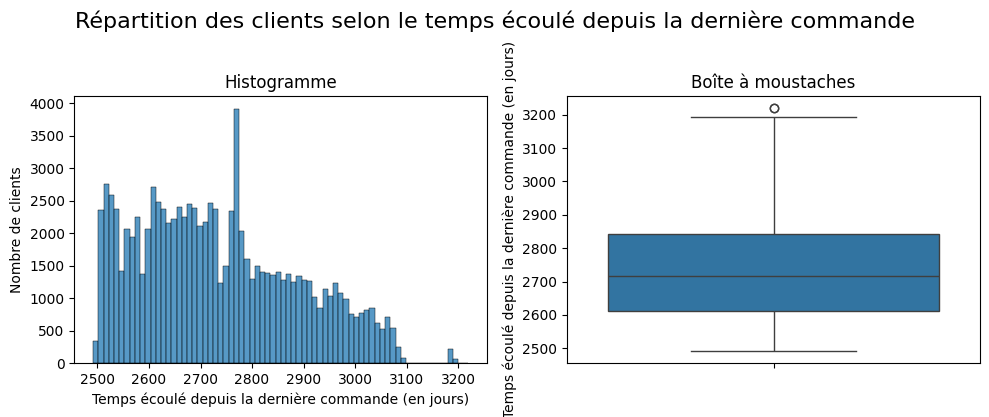

In [27]:
var = numeric_df["recence"]
var_str = "Temps écoulé depuis la dernière commande (en jours)"

fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(10, 4))

sns.histplot(var, ax=axes[0])
axes[0].set_title("Histogramme")
axes[0].set_ylabel("Nombre de clients")
axes[0].set_xlabel(var_str)

sns.boxplot(var, ax=axes[1])
axes[1].set_title("Boîte à moustaches")
axes[1].set_ylabel(var_str)

fig.suptitle("Répartition des clients selon le temps écoulé depuis la dernière commande", fontsize=16, y=1.03)

plt.tight_layout()
plt.show()


On observe à la fois un pic de commandes entre 2700 et 2800 jours avant aujourd'hui et une absence complète de commandes entre 3100 et 3200 jours avant aujourd'hui. Cette période peut potentiellement refléter un perte de données. 

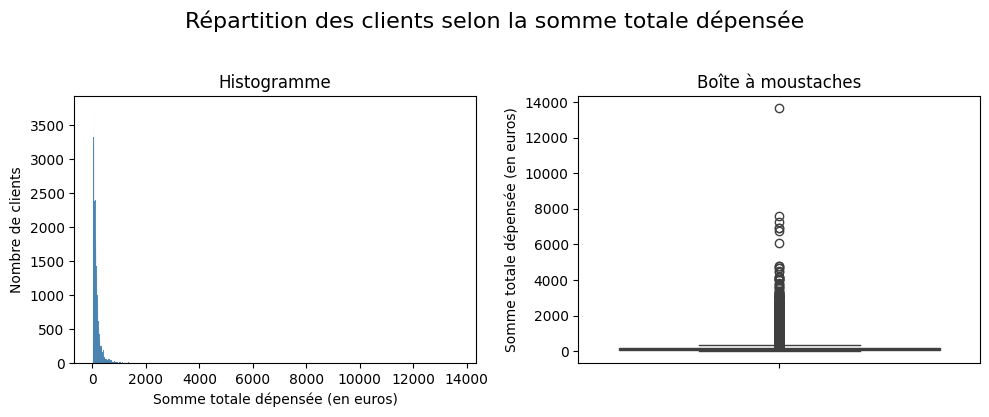

In [28]:
var = numeric_df["depense_totale"]
var_str = "Somme totale dépensée (en euros)"

fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(10, 4))

sns.histplot(var, ax=axes[0])
axes[0].set_title("Histogramme")
axes[0].set_ylabel("Nombre de clients")
axes[0].set_xlabel(var_str)

sns.boxplot(var, ax=axes[1])
axes[1].set_title("Boîte à moustaches")
axes[1].set_ylabel(var_str)

fig.suptitle("Répartition des clients selon la somme totale dépensée", fontsize=16, y=1.03)

plt.tight_layout()
plt.show()

In [29]:
data_filtered.columns

Index(['customer_unique_id', 'customer_state', 'nb_commandes', 'nb_produits',
       'depense_totale', 'recence', 'score_moyen', 'type_produit_prefere'],
      dtype='object')

Text(0.5, 1.0, 'Répartition des clients selon leur Etat')

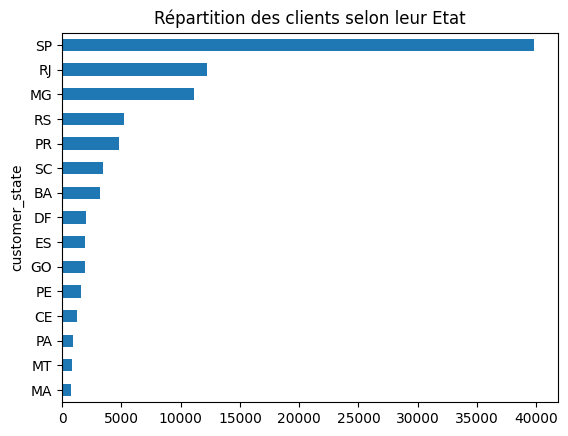

In [30]:
state_counts = data_filtered['customer_state'].value_counts().sort_values(ascending=True)
# Créer le graphique à barres avec les axes inversés
ax = state_counts[-15:].plot(kind='barh')
plt.title('Répartition des clients selon leur Etat')

La grande majorité des clients proviennent de la région de SaoPaulo. Si on encodait la variable en gardant les 26 catégories (i.e. 26 états), on pourrait ajouter du bruit au modèle ou biaiser ses résultats. Ainsi, on choisit de regrouper les états selon les 5 régions suivantes ([source: Wikipedia](https://fr.wikipedia.org/wiki/R%C3%A9gions_du_Br%C3%A9sil)): 
- Centre-Ouest (GO, MT, MS, DF)
- Nord-Est (MA, PI, CE, RN, PB, AL, PE, BA, SE)
- Nord (AC, AP, AM, PA, RO, RR, TO)
- Sud-Est (ES, MG, RJ, SP)
- Sud (PR, RS, SC)

In [31]:
# Dictionnaire de mapping : état → région (en français)
etat_vers_region = {
    # Nord
    "AC": "Nord", "AP": "Nord", "AM": "Nord",
    "PA": "Nord", "RO": "Nord", "RR": "Nord", "TO": "Nord",

    # Nord-Est
    "AL": "Nord-Est", "BA": "Nord-Est", "CE": "Nord-Est",
    "MA": "Nord-Est", "PB": "Nord-Est", "PE": "Nord-Est",
    "PI": "Nord-Est", "RN": "Nord-Est", "SE": "Nord-Est",

    # Centre-Ouest
    "DF": "Centre-Ouest", "GO": "Centre-Ouest",
    "MT": "Centre-Ouest", "MS": "Centre-Ouest",

    # Sud-Est
    "ES": "Sud-Est", "MG": "Sud-Est", "RJ": "Sud-Est", "SP": "Sud-Est",

    # Sud
    "PR": "Sud", "RS": "Sud", "SC": "Sud"
}

data_filtered["customer_region"] = data_filtered["customer_state"].map(etat_vers_region)

Text(0.5, 1.0, 'Répartition des clients selon leur région')

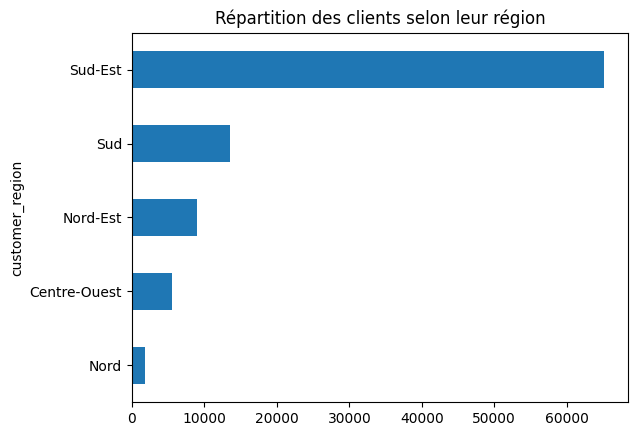

In [32]:
state_counts = data_filtered['customer_region'].value_counts().sort_values(ascending=True)
# Créer le graphique à barres avec les axes inversés
ax = state_counts.plot(kind='barh')
plt.title('Répartition des clients selon leur région')

Comme il s'agit de régions géographiques aux profils démographique et économique très différents, le déséquilibre d'effectif est maintenu mais ce découpage ayant du sens et présentant peu de catégories différentes, on préfèrera cette variable pour la suite :

In [33]:
data_filtered.drop('customer_state', axis = 1, inplace = True)

Text(0.5, 1.0, 'Répartition des clients selon leur type de produit préféré')

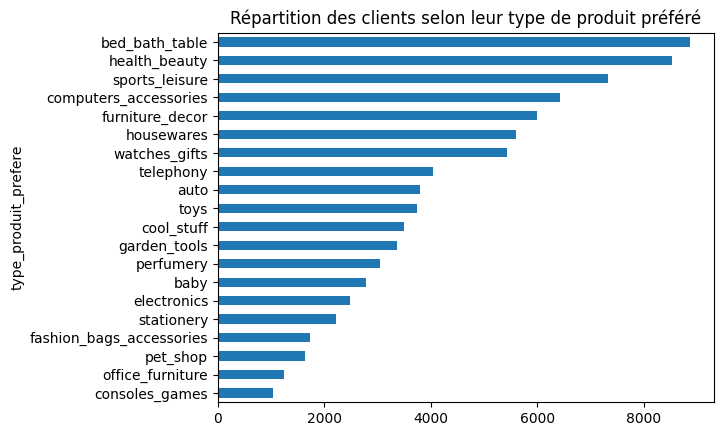

In [34]:
counts = data_filtered['type_produit_prefere'].value_counts().sort_values(ascending=True)
# Créer le graphique à barres avec les axes inversés
ax = counts[-20:].plot(kind='barh')
plt.title('Répartition des clients selon leur type de produit préféré')

Il y a énormément de catégories différentes. Regroupons-les dans des catégories plus larges :

In [35]:
categorie_vers_grande_categorie = {
    # 1. Électronique & Informatique
    'audio': 'Électronique & Informatique',
    'computers': 'Électronique & Informatique',
    'computers_accessories': 'Électronique & Informatique',
    'tablets_printing_image': 'Électronique & Informatique',
    'telephony': 'Électronique & Informatique',
    'fixed_telephony': 'Électronique & Informatique',
    'electronics': 'Électronique & Informatique',
    'consoles_games': 'Électronique & Informatique',
    'cine_photo': 'Électronique & Informatique',

    # 2. Mobilier & Aménagement intérieur
    'furniture_bedroom': 'Mobilier & Aménagement intérieur',
    'furniture_decor': 'Mobilier & Aménagement intérieur',
    'furniture_living_room': 'Mobilier & Aménagement intérieur',
    'furniture_mattress_and_upholstery': 'Mobilier & Aménagement intérieur',
    'office_furniture': 'Mobilier & Aménagement intérieur',
    'home_construction': 'Mobilier & Aménagement intérieur',
    'home_confort': 'Mobilier & Aménagement intérieur',
    'home_comfort_2': 'Mobilier & Aménagement intérieur',
    'housewares': 'Mobilier & Aménagement intérieur',
    
	# 3. Cuisine & Accessoires décoratifs
    'bed_bath_table': 'Cuisine & Accessoires décoratifs',
    'kitchen_dining_laundry_garden_furniture': 'Cuisine & Accessoires décoratifs',
    'la_cuisine': 'Cuisine & Accessoires décoratifs',
    'christmas_supplies': 'Cuisine & Accessoires décoratifs',
    'watches_gifts': 'Cuisine & Accessoires décoratifs',

    # 4. Mode & Accessoires
    'fashio_female_clothing': 'Mode & Accessoires',
    'fashion_male_clothing': 'Mode & Accessoires',
    'fashion_childrens_clothes': 'Mode & Accessoires',
    'fashion_bags_accessories': 'Mode & Accessoires',
    'fashion_shoes': 'Mode & Accessoires',
    'fashion_underwear_beach': 'Mode & Accessoires',
    'fashion_sport': 'Mode & Accessoires',
    'luggage_accessories': 'Mode & Accessoires',

    # 5. Bébé & Enfants
    'baby': 'Bébé & Enfants',
    'diapers_and_hygiene': 'Bébé & Enfants',
    'toys': 'Bébé & Enfants',

    # 6. Alimentation & Boissons
    'food': 'Alimentation & Boissons',
    'food_drink': 'Alimentation & Boissons',
    'drinks': 'Alimentation & Boissons',

    # 7. Santé & Beauté
    'health_beauty': 'Santé & Beauté',
    'perfumery': 'Santé & Beauté',

    # 8. Loisirs & Culture
    'books_general_interest': 'Loisirs & Culture',
    'books_imported': 'Loisirs & Culture',
    'books_technical': 'Loisirs & Culture',
    'cds_dvds_musicals': 'Loisirs & Culture',
    'dvds_blu_ray': 'Loisirs & Culture',
    'music': 'Loisirs & Culture',
    'musical_instruments': 'Loisirs & Culture',
    'art': 'Loisirs & Culture',
    'arts_and_craftmanship': 'Loisirs & Culture',
    'party_supplies': 'Loisirs & Culture',
    'cool_stuff': 'Loisirs & Culture',
    'sports_leisure': 'Loisirs & Culture',

    # 9. Électroménager
    'home_appliances': 'Électroménager',
    'home_appliances_2': 'Électroménager',
    'small_appliances': 'Électroménager',
    'small_appliances_home_oven_and_coffee': 'Électroménager',
    'air_conditioning': 'Électroménager',

    # 10. Animaux
    'pet_shop': 'Animaux',

    # 11. Bricolage & Jardin
    'construction_tools_construction': 'Bricolage & Jardin',
    'construction_tools_lights': 'Bricolage & Jardin',
    'construction_tools_safety': 'Bricolage & Jardin',
    'costruction_tools_garden': 'Bricolage & Jardin',
    'costruction_tools_tools': 'Bricolage & Jardin',
    'garden_tools': 'Bricolage & Jardin',

    # 12. Papeterie & Bureau
    'stationery': 'Papeterie & Bureau',
    'industry_commerce_and_business': 'Papeterie & Bureau',
    'market_place': 'Papeterie & Bureau',
    
	# 13. Auto & Transport
    'auto' : 'Auto & Transport',

    # 14. Autres
    'agro_industry_and_commerce': 'Autres',
    'flowers': 'Autres',
    'security_and_services': 'Autres',
    'signaling_and_security': 'Autres',
}

data_filtered["grand_type_produit_prefere"] = data_filtered["type_produit_prefere"].map(categorie_vers_grande_categorie)

Text(0.5, 1.0, 'Répartition des clients selon leur catégorie de produit préférée')

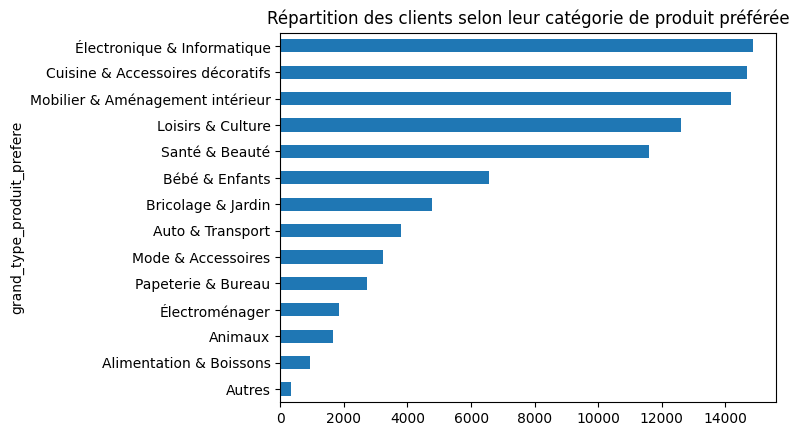

In [36]:
counts = data_filtered['grand_type_produit_prefere'].value_counts().sort_values(ascending=True)
# Créer le graphique à barres avec les axes inversés
ax = counts.plot(kind='barh')
plt.title('Répartition des clients selon leur catégorie de produit préférée')

Le regroupement ne déséquilibre pas le dataset et réduit drastiquement le nombre de catégories différentes. On préfèrera donc cette variable dans la suite :

In [37]:
data_filtered.drop('type_produit_prefere', axis = 1, inplace = True)

In [38]:
data_filtered.columns

Index(['customer_unique_id', 'nb_commandes', 'nb_produits', 'depense_totale',
       'recence', 'score_moyen', 'customer_region',
       'grand_type_produit_prefere'],
      dtype='object')

Y a t-il un lien linéaire entre récence et dépense totale? 

<Axes: title={'center': 'Scatter plot entre récence et dépense'}, xlabel='recence', ylabel='depense_totale'>

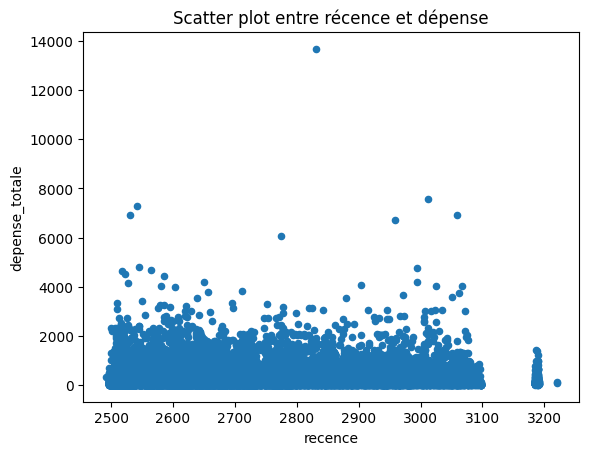

In [39]:
numeric_df.plot.scatter(
    x="recence", y="depense_totale", title="Scatter plot entre récence et dépense"
)

Il ne semble pas y avoir de lien linéaire entre recence et dépense totale. Ceci est possiblement en partie lié au fait que la plupart des clients n'ont fait qu'une seule commande. A l'inverse si tous les clients étaient des clients réguliers, on aurait pu calculer la récence comme la durée moyenne entre deux commandes. Il y aurait alors eu possiblement un lien entre récence et somme dépensée. 

### Matrice de corrélation

Text(0.5, 1.0, 'Matrice de corrélation entre les valiables numériques du dataset')

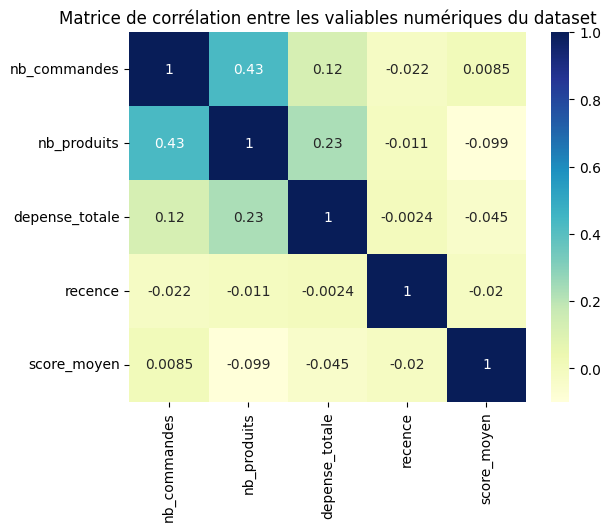

In [40]:
matrix = numeric_df.corr(method="pearson")
sns.heatmap(matrix, cmap="YlGnBu", annot=True)
plt.title("Matrice de corrélation entre les valiables numériques du dataset")

## Encodage des variables catégorielles

In [41]:
data_filtered.columns

Index(['customer_unique_id', 'nb_commandes', 'nb_produits', 'depense_totale',
       'recence', 'score_moyen', 'customer_region',
       'grand_type_produit_prefere'],
      dtype='object')

In [42]:
features_to_encode = ['grand_type_produit_prefere','customer_region']
data_encoded = pd.get_dummies(data_filtered, columns=features_to_encode, prefix='cat')
data_encoded.head()
data_encoded.shape

(95082, 25)

## Enregistrer le DataFrame dans un fichier

In [43]:
data_encoded.to_pickle("clean_dataset.pkl")